# Transfer Learning using PyTorch

In [2]:
!nvidia-smi

Sun Mar 30 09:03:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050      WDDM  |   00000000:10:00.0  On |                  N/A |
|  0%   38C    P0             13W /  130W |     696MiB /   8192MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Load Important Libraries

In [3]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load Data
=========

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we\'re going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants
and bees. There are 75 validation images for each class. Usually, this
is a very small dataset to generalize upon, if trained from scratch.
Since we are using transfer learning, we should be able to generalize
reasonably well.

This dataset is a very small subset of imagenet.


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ajayrana/hymenoptera-data")

print("Path to dataset files:", path)

c:\Users\cu\anaconda3\envs\test\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\cu\.cache\kagglehub\datasets\ajayrana\hymenoptera-data\versions\1


In [5]:
# from the path, paste the files to the current directory
!xcopy $path . /s /e

^C


The command below is to delete the .ipynb_checkpoints folder using linux, but upon checking there is no such file in the dataset

In [ ]:
!rm -R /content/hymenoptera_data/train/.ipynb_checkpoints
!ls /content/hymenoptera_data/test/train -a   #to make sure that the deletion has occurred

!rm -R /content/hymenoptera_data/val/.ipynb_checkpoints
!ls /content/hymenoptera_data/val -a   #to make sure that the deletion has occurred

'rm' is not recognized as an internal or external command,
operable program or batch file.
'ls' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.
'ls' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data\\'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Visualize a few images
======================

Let\'s visualize a few training images so as to understand the data
augmentations.


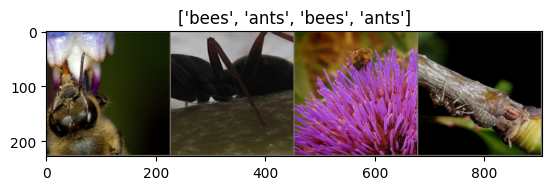

In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model
==================

Now, let\'s write a general function to train a model. Here, we will
illustrate:

-   Scheduling the learning rate
-   Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from
`torch.optim.lr_scheduler`.


In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

## Visualizing the model predictions
=================================

Generic function to display predictions for a few images


In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet
======================

Load a pretrained model and reset final fully connected layer.


In [10]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train and evaluate
==================

It should take around 15-25 min on CPU. On GPU though, it takes less
than a minute.


In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7805 Acc: 0.7295
val Loss: 0.5067 Acc: 0.8235

Epoch 1/24
----------
train Loss: 0.5460 Acc: 0.7828
val Loss: 0.2876 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.5908 Acc: 0.7992
val Loss: 0.3484 Acc: 0.8562

Epoch 3/24
----------
train Loss: 0.8199 Acc: 0.7746
val Loss: 0.5524 Acc: 0.8105

Epoch 4/24
----------
train Loss: 0.4846 Acc: 0.8402
val Loss: 0.3544 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.3175 Acc: 0.8893
val Loss: 0.3097 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.4508 Acc: 0.8361
val Loss: 0.2579 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3320 Acc: 0.8811
val Loss: 0.2399 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.3238 Acc: 0.8484
val Loss: 0.2656 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.2758 Acc: 0.8811
val Loss: 0.3100 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2776 Acc: 0.8975
val Loss: 0.2506 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.1904 Acc: 0.9180
val Loss: 0.2818 Acc: 0.9085

Ep

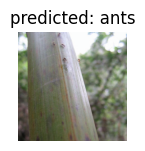

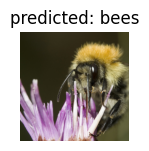

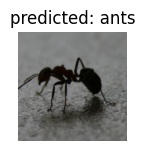

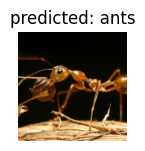

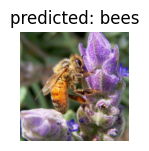

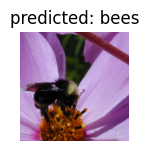

In [15]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor
==================================

Here, we need to freeze all the network except the final layer. We need
to set `requires_grad = False` to freeze the parameters so that the
gradients are not computed in `backward()`.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).


In [16]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate
==================

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don\'t need to be computed for most of the
network. However, forward does need to be computed.


In [17]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5824 Acc: 0.6516
val Loss: 0.4990 Acc: 0.7647

Epoch 1/24
----------
train Loss: 0.6027 Acc: 0.7951
val Loss: 0.2080 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4530 Acc: 0.7869
val Loss: 0.2778 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.4663 Acc: 0.7787
val Loss: 0.2203 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4255 Acc: 0.8115
val Loss: 0.3081 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.4248 Acc: 0.8074
val Loss: 0.2109 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3931 Acc: 0.8443
val Loss: 0.2139 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3228 Acc: 0.8566
val Loss: 0.1924 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.2721 Acc: 0.8934
val Loss: 0.1999 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3246 Acc: 0.8525
val Loss: 0.2164 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2817 Acc: 0.8730
val Loss: 0.2147 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.2811 Acc: 0.8811
val Loss: 0.1995 Acc: 0.9346

Ep

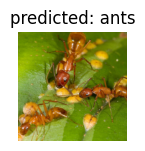

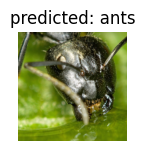

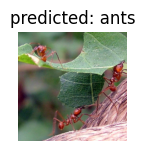

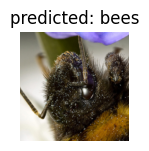

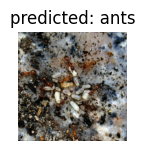

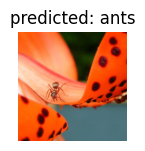

In [18]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Inference on custom images
==========================

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.


In [19]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

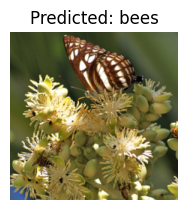

In [20]:
visualize_model_predictions(
    model_conv,
    img_path='hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

## Further Learning
================

If you would like to learn more about the applications of transfer
learning, checkout the
* [Quantized Transfer Learning for Computer Vision
Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).


# Supplementary Activity

In a new notebook, perform the following:
1. Choose a pretrained model.
2. Finetune on your dataset from the previous activity.
3. Evaluate the performance of the previous model to this finetuned model.

4. Utilize the pretrained ConvNet model as fixed feature extractor.
5. Evaluate the performance of the previous model to this finetuned model.

6.  Discuss the following:
  * How did finetuning affect your performance?
  * Which of the different situations for rule of thumb were applicable to you?

In [21]:
!pip install facenet-pytorch

  Using cached torch-2.2.2-cp312-cp312-win_amd64.whl.metadata (26 kB)
  Using cached torchvision-0.17.2-cp312-cp312-win_amd64.whl.metadata (6.6 kB)
Using cached torch-2.2.2-cp312-cp312-win_amd64.whl (198.5 MB)
Using cached torchvision-0.17.2-cp312-cp312-win_amd64.whl (1.2 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu118
    Uninstalling torch-2.6.0+cu118:
      Successfully uninstalled torch-2.6.0+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.21.0+cu118
    Uninstalling torchvision-0.21.0+cu118:
      Successfully uninstalled torchvision-0.21.0+cu118


  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.6.0+cu118 requires torch==2.6.0+cu118, but you have torch 2.2.2 which is incompatible.


In [22]:
import torch
from PIL import Image
from facenet_pytorch import InceptionResnetV1, MTCNN

# Load pre-trained FaceNet model
model = InceptionResnetV1(pretrained='vggface2').eval()
mtcnn = MTCNN(image_size=160, margin=0)

# Testing if model is working on the previous dataset
image_folder = 'images/'

for file_name in os.listdir(image_folder):
    file_path = os.path.join(image_folder, file_name)
    # Opening the image
    img = Image.open(file_path).convert('RGB')

    # Detect face and get probability
    x_aligned, prob = mtcnn(img, return_prob=True)

    if x_aligned is not None:
        print(f'Face detected in {file_name} with probability: {prob:.6f}')
    else:
        print(f'No face detected in {file_name}')

Face detected in drowsy1.png with probability: 0.953710
Face detected in drowsy10.png with probability: 0.991641
Face detected in drowsy2.png with probability: 0.999999
Face detected in drowsy3.png with probability: 0.999883
Face detected in drowsy4.png with probability: 0.996684
Face detected in drowsy5.png with probability: 0.984176
Face detected in drowsy6.png with probability: 0.999992
Face detected in drowsy7.png with probability: 0.999854
Face detected in drowsy8.png with probability: 0.999995
Face detected in drowsy9.png with probability: 0.999791
Face detected in Normal1.png with probability: 0.999953
Face detected in Normal10.png with probability: 0.999997
Face detected in Normal2.png with probability: 0.997241
Face detected in Normal3.png with probability: 0.999999
Face detected in Normal4.png with probability: 0.999997
Face detected in Normal5.png with probability: 0.999824
Face detected in Normal6.png with probability: 0.999168
Face detected in Normal7.png with probability:

Finetune on your dataset from the previous activity

In [23]:
import os
import pandas as pd
from torch.utils.data import Dataset
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [24]:
from torchvision import transforms

transforms = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToPILImage(),
    transforms.Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),
    transforms.ToTensor()
])

dataset = CustomImageDataset(
    annotations_file="annotations.csv",
    img_dir="images/",
    transform=transforms
)

In [25]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

train, test = random_split(dataset, [0.7, 0.3])

train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test, batch_size=64, shuffle=True)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=2
).to(device)

In [27]:
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from facenet_pytorch import training

# Define parameters
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, milestones=[5, 10])
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'accuracy': training.accuracy
}
epochs = 24


writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, test_dataloader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_dataloader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, test_dataloader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |     1/1    | loss:    0.7794 | accuracy:    0.3333   

Epoch 1/24
----------
Train |     1/1    | loss:    0.8216 | accuracy:    0.5000   
Valid |     1/1    | loss:    0.4380 | accuracy:    0.8333   

Epoch 2/24
----------
Train |     1/1    | loss:    0.1204 | accuracy:    1.0000   
Valid |     1/1    | loss:    0.5372 | accuracy:    0.6667   

Epoch 3/24
----------
Train |     1/1    | loss:    0.0134 | accuracy:    1.0000   
Valid |     1/1    | loss:    1.5678 | accuracy:    0.8333   

Epoch 4/24
----------
Train |     1/1    | loss:    0.0003 | accuracy:    1.0000   
Valid |     1/1    | loss:    6.9464 | accuracy:    0.6667   

Epoch 5/24
----------
Train |     1/1    | loss:    0.0002 | accuracy:    1.0000   
Valid |     1/1    | loss:   15.1041 | accuracy:    0.6667   

Epoch 6/24
----------
Train |     1/1    | loss:    0.0002 | accuracy:    1.0000   
Valid |     1/1    | loss:   11.2858 | accuracy:    0.6667   

Epoch 7/24
----------
Train |     

Utilize the pretrained ConvNet model as fixed feature extractor.

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2'
).to(device)
resnet.last_linear = torch.nn.Linear(resnet.last_linear.in_features, 512).to(device)

In [29]:
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from facenet_pytorch import training

# Define parameters
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, milestones=[5, 10])
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'accuracy': training.accuracy
}
epochs = 24


writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, test_dataloader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_dataloader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, test_dataloader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |     1/1    | loss:    9.0140 | accuracy:    0.0000   

Epoch 1/24
----------
Train |     1/1    | loss:    9.1605 | accuracy:    0.0000   
Valid |     1/1    | loss:    8.1362 | accuracy:    0.1667   

Epoch 2/24
----------
Train |     1/1    | loss:    6.3381 | accuracy:    0.4286   
Valid |     1/1    | loss:   18.3985 | accuracy:    0.6667   

Epoch 3/24
----------
Train |     1/1    | loss:    2.3644 | accuracy:    1.0000   
Valid |     1/1    | loss:  192.9394 | accuracy:    0.6667   

Epoch 4/24
----------
Train |     1/1    | loss:    1.8067 | accuracy:    1.0000   
Valid |     1/1    | loss:  171.9576 | accuracy:    0.6667   

Epoch 5/24
----------
Train |     1/1    | loss:    1.3878 | accuracy:    1.0000   
Valid |     1/1    | loss:    6.5684 | accuracy:    0.8333   

Epoch 6/24
----------
Train |     1/1    | loss:    0.5950 | accuracy:    1.0000   
Valid |     1/1    | loss:    5.5204 | accuracy:    0.6667   

Epoch 7/24
----------
Train |     

In [30]:
help(InceptionResnetV1)

Help on class InceptionResnetV1 in module facenet_pytorch.models.inception_resnet_v1:

class InceptionResnetV1(torch.nn.modules.module.Module)
 |  InceptionResnetV1(pretrained=None, classify=False, num_classes=None, dropout_prob=0.6, device=None)
 |
 |  Inception Resnet V1 model with optional loading of pretrained weights.
 |
 |  Model parameters can be loaded based on pretraining on the VGGFace2 or CASIA-Webface
 |  datasets. Pretrained state_dicts are automatically downloaded on model instantiation if
 |  requested and cached in the torch cache. Subsequent instantiations use the cache rather than
 |  redownloading.
 |
 |  Keyword Arguments:
 |      pretrained {str} -- Optional pretraining dataset. Either 'vggface2' or 'casia-webface'.
 |          (default: {None})
 |      classify {bool} -- Whether the model should output classification probabilities or feature
 |          embeddings. (default: {False})
 |      num_classes {int} -- Number of output classes. If 'pretrained' is set and

In [33]:
# Print the model architecture
print(resnet)

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

Test Codes:

In [34]:
resnet_test = InceptionResnetV1(
    classify=True,
    pretrained='vggface2'
).to(device)

print(resnet_test)

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [35]:
resnet_test.fc = torch.nn.Linear(resnet_test.last_linear.in_features, 2).to(device)
print(resnet_test)

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [36]:
for param in resnet_test.parameters():
    param.requires_grad = False

In [52]:
resnet_test2 = InceptionResnetV1(
    classify=True,
    pretrained='vggface2').to(device)


In [53]:
# Freeze all layers except the last linear layer
for name, param in resnet_test2.named_parameters():
    if "logits" not in name:  # Exclude the last linear layer
        param.requires_grad = False

In [62]:
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
from facenet_pytorch import training

# Define parameters
optimizer = optim.Adam(resnet_test2.logits.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'accuracy': training.accuracy
}
epochs = 100


writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet_test2.eval()
training.pass_epoch(
    resnet_test2, loss_fn, test_dataloader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet_test2.train()
    training.pass_epoch(
        resnet_test2, loss_fn, train_dataloader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet_test2.eval()
    training.pass_epoch(
        resnet_test2, loss_fn, test_dataloader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |     1/1    | loss:   12.2269 | accuracy:    0.1667   

Epoch 1/100
----------
Train |     1/1    | loss:    4.6715 | accuracy:    0.6429   
Valid |     1/1    | loss:   12.2180 | accuracy:    0.1667   

Epoch 2/100
----------
Train |     1/1    | loss:    4.5144 | accuracy:    0.6429   
Valid |     1/1    | loss:   12.1775 | accuracy:    0.1667   

Epoch 3/100
----------
Train |     1/1    | loss:    4.0541 | accuracy:    0.7143   
Valid |     1/1    | loss:   12.1533 | accuracy:    0.1667   

Epoch 4/100
----------
Train |     1/1    | loss:    4.0984 | accuracy:    0.6429   
Valid |     1/1    | loss:   12.1147 | accuracy:    0.1667   

Epoch 5/100
----------
Train |     1/1    | loss:    3.7351 | accuracy:    0.6429   
Valid |     1/1    | loss:   12.0688 | accuracy:    0.1667   

Epoch 6/100
----------
Train |     1/1    | loss:    4.3297 | accuracy:    0.6429   
Valid |     1/1    | loss:   12.0363 | accuracy:    0.1667   

Epoch 7/100
----------
Train